In [86]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
from functools import reduce
import random
import math
import matplotlib.pyplot as plt
import pickle

In [94]:
def generate_points_distribution(data_num=2000, dist_type="circle"):
    if dist_type == 'spiral':
        theta = np.linspace(0, 5*np.pi, data_num)  # 각도 범위를 정의합니다.
        radius = np.linspace(0, 0.35, data_num)  # 반지름 범위를 정의합니다.
        xx = 0.5 + radius * np.cos(theta) + 0.012 * np.random.randn(data_num)  # x 좌표 계산
        yy = 0.4 + radius * np.sin(theta) + 0.012 * np.random.randn(data_num)  # y 좌표 계산
    
    elif dist_type == 'box':
        xx = np.random.uniform(0.4, 0.8, data_num) + 0.012 * np.random.randn(data_num)  # x 좌표 계산
        yy = np.random.uniform(0.2, 0.7, data_num) + 0.012 * np.random.randn(data_num)  # y 좌표 계산

    elif dist_type == 'curve':
        xx = np.linspace(0.15, 0.85, data_num) + 0.02 * np.random.randn(data_num)  # x 좌표 계산
        yy = 3.8 * xx*xx - 3.8 * xx + 1.2 + 0.03 * np.random.randn(data_num)  # y 좌표 계산
    
    elif dist_type == 'circle':
        radius = 0.25
        theta = np.linspace(0, 2 * np.pi, data_num)  # 각도 범위를 정의합니다.
        xx = radius * np.cos(theta) + 0.5 + 0.02 * np.random.randn(data_num)  # x 좌표 계산
        yy = radius * np.sin(theta) + 0.55 + 0.02 * np.random.randn(data_num)  # y 좌표 계산

    data = np.column_stack((xx, yy))  # x와 y 좌표를 합쳐서 데이터 생성
    np.random.shuffle(data)
    
    return data

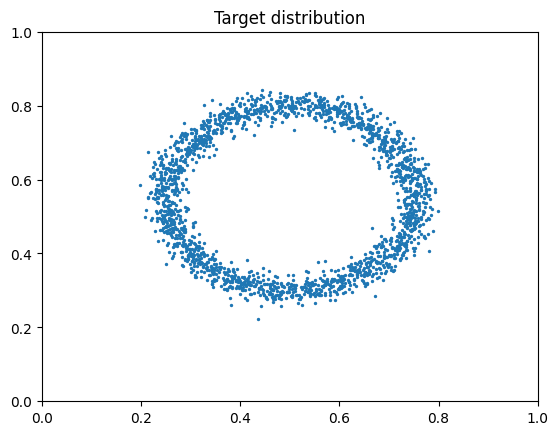

In [96]:
x = generate_points_distribution(2000, 'circle')
plt.scatter(x[:,0], x[:,1], s=2.0)
plt.title('Target distribution')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

In [97]:
# setting torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [102]:
noise_qubits = 6
output_qubits = 2
code_qubits = 2
assert(output_qubits <= noise_qubits-code_qubits) # 출력 큐빗은 noise qubit미만이어야 한다.
n_qubits = noise_qubits + code_qubits

n_layers = 15
BATCH_SIZE = 16
print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))

dev = qml.device("default.qubit", wires=n_qubits)
# dev = qml.device("ionq.simulator", wires=2)
# dev = qml.device("ionq.qpu", wires=2)

n_qubits = 8 n_layers = 15


In [113]:
coeff = 0.15

def generator_init(generator_input):
    for i in range(n_qubits):
        qml.RY(generator_input[i]*np.pi/2, wires=i) # TODO: *a 해서 값 범위 맞추기

def generator_layer(params):
    for i in range(n_qubits):
        qml.RX(params[i][0], wires=i)
        qml.RY(params[i][1], wires=i)
        qml.RZ(params[i][2], wires=i)
    
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])

@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    """
    quantum circuit nodeq1
    generator_input (np.array(큐빗)) : 생성기 입력 seed (noise + code)
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    마지막 측정은 모두 Z로
    """

    generator_init(generator_input)

    for param in params:
        generator_layer(param)

    return [qml.probs(wires=i) for i in range(n_qubits)]

def generator_forward(params, generator_input):
    # 제너레이터 돌리고 결과 return하는 함수
    generator_output = [generator_circuit(params, single_in)[::2] for single_in in generator_input]
    generator_output = torch.stack(generator_output) # (BATCH_SIZE, n_qubits) 차원
    generator_output = 2 / np.pi * torch.arcsin(torch.sqrt(generator_output)) # (BATCH_SIZE, n_qubits) 차원

    return generator_output[:, :output_qubits], generator_output[:, -code_qubits:] # noise, code 순서로 반환


def generator_train_step(params, generator_input, use_mine = False, _qmine = False):
    '''
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    generator_input (torch.Tensor(BATCH_SIZE, n_qubits)): 생성기 입력 seed (noise + code). -1~1 사이의 값
    '''
    code_input = generator_input[:, -code_qubits:] # 입력중에서 code만 뽑는다. (BATCH_SIZE, code_qubits)

    generator_output, code_output = generator_forward(params, generator_input) # 출력을 뽑아낸다
    generator_output = generator_output.to(torch.float32) # (BATCH_SIZE, output_qubits)
    
    disc_output = discriminator(generator_output) # 밑에 코드에서 정의됨
    gan_loss = torch.log(1-disc_output).mean()
    # print("gan_loss = ", gan_loss, gan_loss.shape)
    
    t = (code_input - code_output).pow(2).mean()

    if use_mine:
        pred_xy = mine(code_input, generator_output)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, generator_output)
        mi = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
        gan_loss -= coeff * mi

    elif _qmine:
        gan_loss += 0 # TODO: qmine loss 추가하기

    return generator_output, gan_loss+t*0, gan_loss, t # TODO: 이건 분석용으로 넣어놓음.지워야 함.


def prediction(params, image, debug=False):
    prob_0 = 0
    prob_1 = 0
    for i in range(n_layers):
        prob_0 += circuit(params[:i+1], (image, 0))
        prob_1 += circuit(params[:i+1], (image, 1))

    if (debug):
        return (int(prob_0 <= prob_1), prob_0, prob_1)
    return int(prob_0 <= prob_1)

In [114]:
import torch.nn as nn
from torch.nn import functional as F

class LinearDiscriminator(nn.Module):
    def __init__(self, input_dim=output_qubits):
        super().__init__()
        self.hidden_size = 100
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, 1),
            nn.Sigmoid())

        self.input_dim = input_dim

    def forward(self, x):
        if(len(x.shape) != 2):
            x = x.view(x.shape[0], -1)

        return self.layers(x)


class LinearMine(nn.Module):
    def __init__(self):
        super(LinearMine, self).__init__()
        H = 10
        self.fc1 = nn.Linear(code_qubits, H)
        self.fc2 = nn.Linear(output_qubits, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2

disc_loss_fn = nn.BCELoss()
def disc_cost_fn(real_input, fake_input, smoothing=False):
    batch_num = real_input.shape[0]

    disc_real = discriminator(real_input)
    disc_fake = discriminator(fake_input)

    real_label = torch.ones((batch_num, 1)).to(device)
    fake_label = torch.zeros((batch_num, 1)).to(device)
    
    if smoothing:
        real_label = real_label - 0.3*torch.rand(real_label.shape).to(device)
    
    loss = 0.5 * (disc_loss_fn(disc_real, real_label) + disc_loss_fn(disc_fake, fake_label))
    
    return loss


In [115]:
generator_params = Variable(torch.tensor(np.random.normal(-np.pi, np.pi, (n_layers, n_qubits, 3))), requires_grad=True)
print("parameter shape: ", generator_params.shape)

discriminator = LinearDiscriminator()
mine = LinearMine()

parameter shape:  torch.Size([15, 8, 3])


In [118]:
G_lr = 1e-3
D_lr = 1e-3
M_lr = 1e-3
G_opt = torch.optim.Adam([generator_params], lr=G_lr)
D_opt = torch.optim.Adam(discriminator.parameters(), lr=D_lr)
M_opt = torch.optim.Adam(mine.parameters(), lr=M_lr)

In [120]:
import os
epoch = 300
title = 'try17'
if not os.path.exists(f'result/{title}'):
    os.makedirs(f'result/{title}')

recorder_keywords = ['d_loss', 'g_loss', 'a_loss', 'b_loss', 'mi']
recorder = {k: [] for k in recorder_keywords}
final_rep = 0

for rep in range(1, epoch+1):
    np.random.shuffle(x)
    iter_num = int(len(x) * 0.5 //BATCH_SIZE) # 매번 50% 추출해서 학습. 셔플하니까 자투리 생기는건 무시.
    
    G_loss_sum = 0.0
    D_loss_sum = 0.0
    a_loss_sum = 0.0
    b_loss_sum = 0.0
    mi_sum = 0.0
    pbar = tqdm(range(iter_num))
    log_gen_output = []
    
    for i in pbar:
        batch = torch.FloatTensor(x[BATCH_SIZE * i : BATCH_SIZE * i + BATCH_SIZE])
        
        # train generator
        generator_seed = torch.rand((BATCH_SIZE, n_qubits)) * 2 - 1
        generator_output, generator_loss, a, b = generator_train_step(generator_params, generator_seed, use_mine=True, _qmine=False)
        G_opt.zero_grad()
        generator_loss.requires_grad_(True)
        generator_loss.backward()
        G_opt.step()
        a_loss_sum += a.detach().numpy()
        b_loss_sum += b.detach().numpy()

        # train discriminator
        fake_input = generator_output.detach().to(torch.float32)
        disc_loss = disc_cost_fn(batch, fake_input)
        D_opt.zero_grad()
        disc_loss.requires_grad_(True)
        disc_loss.backward()
        D_opt.step()

        # train mine
        code_input = generator_seed[:, -code_qubits:] 
        pred_xy = mine(code_input, fake_input)
        code_input_shuffle = code_input[torch.randperm(BATCH_SIZE)]
        pred_x_y = mine(code_input_shuffle, fake_input)
        mi = -torch.mean(pred_xy) + torch.log(torch.mean(torch.exp(pred_x_y)))
        M_opt.zero_grad()
        mi.requires_grad_(True)
        mi.backward()
        M_opt.step()


        D_loss_sum += disc_loss.item()
        G_loss_sum += generator_loss.item()
        mi_sum -= mi.item() # (-1)곱해져 있어서 빼야함.
        a_loss_sum += a.item()
        b_loss_sum += b.item()

        pbar.set_postfix({'G_loss': G_loss_sum/(i+1), 'D_loss': D_loss_sum/(i+1), 'MI': mi_sum/(i+1)})
        log_gen_output.append(fake_input.numpy())

    recorder['d_loss'].append(D_loss_sum/iter_num)
    recorder['g_loss'].append(G_loss_sum/iter_num)
    recorder['a_loss'].append(a_loss_sum/iter_num)
    recorder['b_loss'].append(b_loss_sum/iter_num)
    recorder['mi'].append(mi_sum/iter_num)
    
    log_gen_output = np.concatenate(log_gen_output, axis=0)
    print("epoch: {}, D_loss: {}, G_loss: {}, MI = {}".format(rep, D_loss_sum/iter_num, G_loss_sum/iter_num, mi_sum/iter_num))
    print("a_loss: {}, b_loss: {}".format(a_loss_sum, b_loss_sum))
    print("좌표값 평균 = ", np.mean(log_gen_output[:,0]), np.mean(log_gen_output[:,1]))
    plt.title('Epoch {0}'.format(rep))
    plt.scatter(log_gen_output[:,0], log_gen_output[:,1], s=2.0)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.savefig(f'result/{title}/{rep}.png')
    plt.show()
    final_rep = rep

  0%|          | 0/62 [00:00<?, ?it/s]

## 결과 plot하는 코드

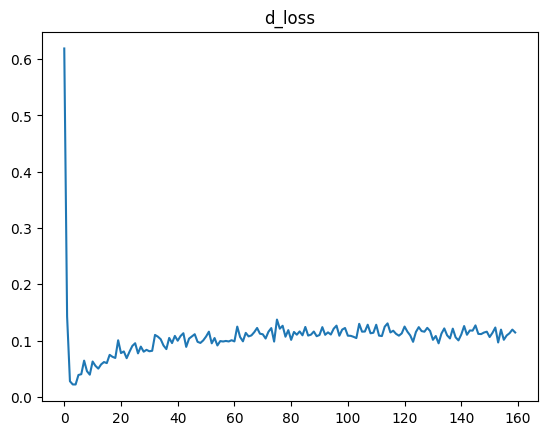

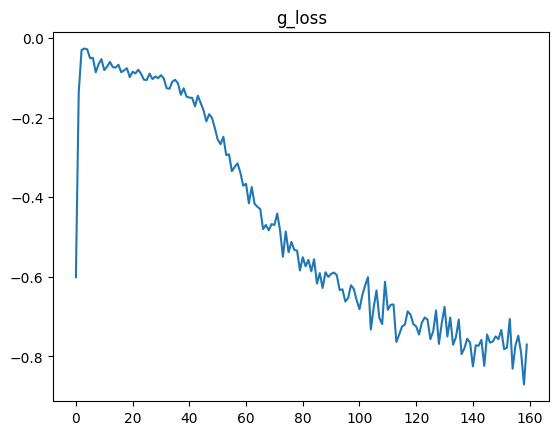

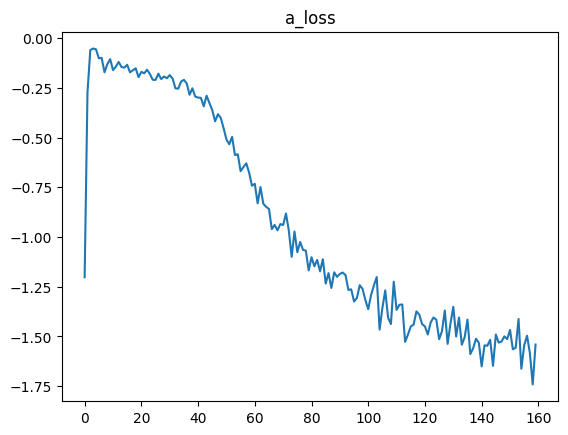

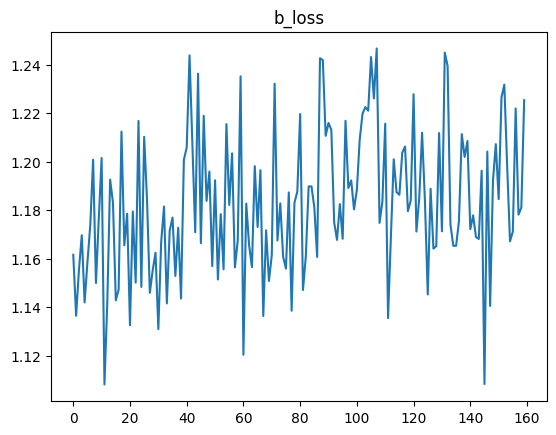

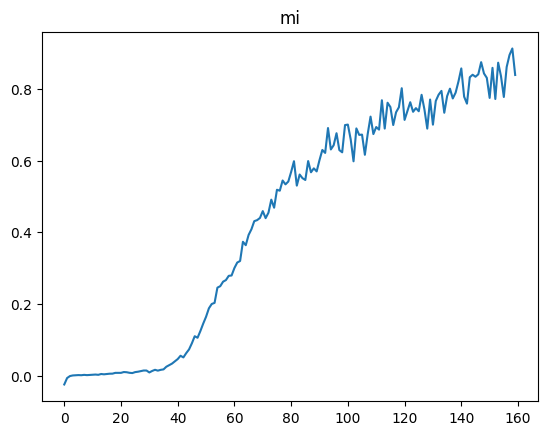

In [112]:
import matplotlib.pyplot as plt
plot_list = ['d_loss', 'g_loss', 'a_loss', 'b_loss', 'mi']
for key in plot_list:
    plt.figure()
    plt.title(key)
    plt.plot(recorder[key])
    plt.savefig(f'result/{title}/{key}.png')
    plt.show()


In [119]:
with open(f'result/{title}/param.txt', 'w') as f:
    f.write('G_lr = {}\n'.format(G_lr))
    f.write('D_lr = {}\n'.format(D_lr))
    f.write('M_lr = {}\n'.format(M_lr))
    f.write('coeff = {}\n'.format(coeff))

## 모델 저장 스크립트

In [110]:
with open(f'result/{title}/discriminator.pkl', 'wb') as file:
    pickle.dump(discriminator, file)

with open(f'result/{title}/generator.pkl', 'wb') as file:
    pickle.dump(generator_params, file)

100%|██████████| 500/500 [00:28<00:00, 17.65it/s]


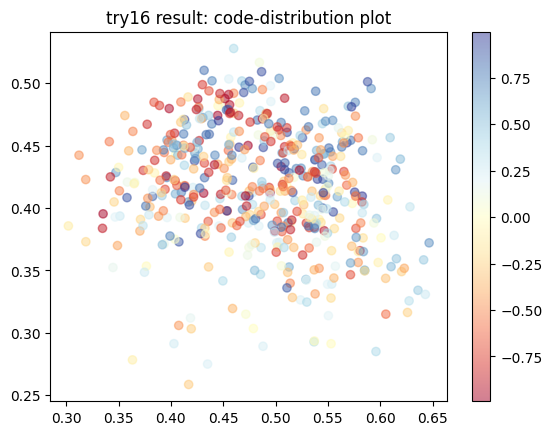

100%|██████████| 500/500 [00:28<00:00, 17.67it/s]


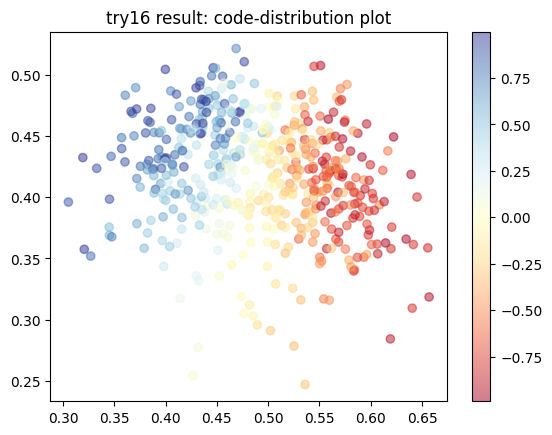

In [111]:
for code_ind in range(code_qubits): # 모든 코드마다 색상읃 달리하여 plot
    inputs = []
    outputs = []

    for i in tqdm(range(500)):
        with torch.no_grad():
            z = np.random.uniform(-1, 1, (1, n_qubits, 1))
            code_input = z[:, -code_qubits:].reshape(code_qubits) # 입력 z중에서 code를 추출한다.
            generator_output, _ = generator_forward(generator_params, z)
            generator_output = generator_output.cpu().numpy().reshape(output_qubits)
            outputs.append(generator_output)
            inputs.append(code_input[code_ind])

    outputs = np.array(outputs)
    plt.scatter(outputs[:, 0], outputs[:, 1], c=inputs, cmap='RdYlBu', alpha=0.5)
    plt.colorbar()  # 색상 막대 추가
    plt.title(f'{title} result: code-distribution plot')
    plt.savefig(f'result/{title}/code_{code_ind}_{final_rep}.png')
    plt.show()


In [42]:
import pandas as pd
df = pd.DataFrame({'x': outputs[:, 0], 'y': outputs[:, 1], 'c': inputs})
df.corr()

,x,y,c
x,1.000000,-0.048270,-0.929722
y,-0.048270,1.000000,0.160922
c,-0.929722,0.160922,1.000000


## 모델 불러오는 스크립트

title변수가 디렉토리를 지정합니다.

In [40]:
import pickle

with open(f'result/{title}/discriminator2.pkl', 'rb') as file:
    discriminator = pickle.load(file)

with open(f'result/{title}/generator.pkl', 'rb') as file:
    generator_params = pickle.load(file)

In [21]:
title = 'try14'

In [39]:
with open(f'result/{title}/discriminator2.pkl', 'wb') as file:
    pickle.dump(discriminator, file)

with open(f'result/{title}/generator2.pkl', 'wb') as file:
    pickle.dump(generator_params, file)